In [1]:
""" The Goal here is to Genarate a signal tabel. from the signal clmn
    which includes
    1. Genarate Sl
    2. Genarate Tp < hardCoded - Dinamic is comming in next version
 """

' The Goal here is to Genarate a signal tabel. from the signal clmn\n    which includes\n    1. Genarate Sl\n    2. Genarate Tp < hardCoded - Dinamic is comming in next version\n '

In [2]:
""" IMPORTING all"""

import mplfinance as mpf
import numpy as np
import pandas as pd

from resampler import EnterpriseDataResampler
from tafm import create_analyzer, IndicatorConfig
from ChartterX5 import Chartter

In [3]:
import pandas as pd

# Read the saved parquet file
ohlcv = pd.read_parquet("ohlcv-1M-mt5.parquet")


In [4]:
ohlcv = ohlcv.rename(columns={
    "tickvol": "vol"  # fix spelling too
})
ohlcv.head(3)


,open,high,low,close,vol,datetime
0,2064.593,2064.659,2063.809,2063.809,1,2024-01-01 23:05:00
1,2063.707,2063.937,2063.301,2063.770,1,2024-01-01 23:06:00
2,2063.714,2064.617,2063.714,2064.364,1,2024-01-01 23:07:00


In [5]:
resampler = EnterpriseDataResampler()

dta = resampler.resample_data(
        resampler.filter_business_data(
            resampler.date_filter.filter_by_date_range(
                ohlcv,
                start_date="2024-10-01",
                end_date="2024-10-02"
            ),
            business_hours_only=False,
            weekdays_only=True
        ),
        period="1T"
    ).set_index("datetime")

2025-09-26 16:36:19,174 - DataResampler - INFO - __init__:624 - EnterpriseDataResampler initialized successfully
2025-09-26 16:36:19,174 - INFO - EnterpriseDataResampler initialized successfully
2025-09-26 16:36:19,894 - DataResampler - INFO - filter_by_date_range:201 - Date filtering completed: 351641 -> 1378 rows (range: 2024-10-01 to 2024-10-02, time: 0.676s)
2025-09-26 16:36:19,894 - INFO - Date filtering completed: 351641 -> 1378 rows (range: 2024-10-01 to 2024-10-02, time: 0.676s)
2025-09-26 16:36:19,965 - DataResampler - INFO - filter_by_weekdays:276 - Weekday filtering: 1378 -> 1378 rows (days: Mon, Tue, Wed, Thu, Fri)
2025-09-26 16:36:19,965 - INFO - Weekday filtering: 1378 -> 1378 rows (days: Mon, Tue, Wed, Thu, Fri)
2025-09-26 16:36:20,363 - DataResampler - INFO - validate_dataframe:441 - Successfully validated DataFrame with 1378 rows
2025-09-26 16:36:20,363 - INFO - Successfully validated DataFrame with 1378 rows
2025-09-26 16:36:20,562 - DataResampler - INFO - resample_da

In [6]:
"""Applying tecNical Ananlisis.."""
dta = dta.rename(columns={
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "vol": "Volume"  # fix spelling too
})

analyzer = create_analyzer(dta)

analyzer.add_indicator(IndicatorConfig(name='RSI', period=14, source_column='Close'))
analyzer.add_indicator(IndicatorConfig(name='EMA', period=15, source_column='RSI_14'))


2025-09-26 16:36:20,619 - INFO - Loaded 161 TALib indicators
2025-09-26 16:36:20,624 - INFO - OHLCV validation: {'Open': True, 'High': True, 'Low': True, 'Close': True, 'Volume': True}
2025-09-26 16:36:20,648 - INFO - Initialized analyzer - Shape: (1378, 5), Memory: 0.06MB
2025-09-26 16:36:49,423 - INFO - ✓ Added indicator RSI_14 in 28.7709s
2025-09-26 16:36:52,791 - INFO - ✓ Added indicator EMA_15 in 3.0058s


In [7]:
#>=Signal Genarator

analyzer.crossed_up('RSI_14', 'EMA_15')

analyzer.df.tail(10)

2025-09-26 16:37:25,494 - INFO - ✓ RSI_14 crossed_up EMA_15 -> RSI_14_crossed_up_EMA_15 (1.4431s)


,Open,High,Low,Close,Volume,RSI_14,EMA_15,RSI_14_crossed_up_EMA_15
datetime,,,,,,,,
2024-10-01 23:51:00,2660.494,2660.775,2660.455,2660.753,42,45.053087,44.207736,1
2024-10-01 23:52:00,2660.752,2660.947,2660.752,2660.851,30,47.201840,44.581999,0
2024-10-01 23:53:00,2660.853,2660.922,2660.560,2660.560,44,41.955208,44.253650,0
2024-10-01 23:54:00,2660.581,2660.800,2660.581,2660.637,48,43.737278,44.189104,0
2024-10-01 23:55:00,2660.643,2660.780,2660.484,2660.600,43,43.053267,44.047124,0
2024-10-01 23:56:00,2660.561,2660.595,2660.361,2660.539,47,41.890116,43.777498,0
2024-10-01 23:57:00,2660.497,2660.553,2660.353,2660.553,44,42.275570,43.589757,0
2024-10-01 23:58:00,2660.568,2660.682,2660.436,2660.508,48,41.326667,43.306871,0
2024-10-01 23:59:00,2660.514,2660.514,2660.359,2660.361,35,38.302220,42.681289,0


In [8]:
ohlcv = analyzer.df.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"  # fix spelling too
})


In [9]:
import pandas as pd

# --- Define Forex sessions in UTC ---
sessions = {
    "Tokyo": ("00:00", "09:00"),
    "London": ("08:00", "17:00"),
    "New_York": ("13:00", "22:00"),
    "Sydney": ("22:00", "07:00")
}

# --- Function to filter a session ---
def get_session(df, start_time, end_time):
    times = df.index.time
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()

    if start < end:
        return df.between_time(start_time, end_time)
    else:
        return df[(times >= start) | (times <= end)]

# --- Split OHLCV into sessions ---
session_dfs = {name: get_session(ohlcv, start, end) for name, (start, end) in sessions.items()}

# --- Extract signal times (RSI_14_above_EMA_15 == 1) ---
signal_times = ohlcv.index[ohlcv['RSI_14_crossed_up_EMA_15'] == 1]

# --- Access individual sessions ---
tokyo    = session_dfs["Tokyo"]
london   = session_dfs["London"]
new_york = session_dfs["New_York"]
sydney   = session_dfs["Sydney"]

# Optional: inspect
for name, df in session_dfs.items():
    print(f"{name} session: {len(df)} rows, signals: {df['RSI_14_crossed_up_EMA_15'].sum()}")

# --- Now signal_times can be passed to Chartter/ mplfinance vlines ---
# Example:
# chartter.plot(ohlcv, vlines={"tlines": signal_times.to_list(), "colors":"white", "linewidths":0.7, "linestyle":"--"})



Tokyo session: 542 rows, signals: 56
London session: 541 rows, signals: 43
New_York session: 478 rows, signals: 33
Sydney session: 541 rows, signals: 58


In [10]:
signal_times[:10]

DatetimeIndex(['2024-10-01 00:29:00', '2024-10-01 00:43:00',
               '2024-10-01 00:54:00', '2024-10-01 01:03:00',
               '2024-10-01 01:07:00', '2024-10-01 01:17:00',
               '2024-10-01 01:21:00', '2024-10-01 01:29:00',
               '2024-10-01 01:35:00', '2024-10-01 01:45:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [11]:
# Filter rows where condition is true
signal_times = tokyo.index[tokyo['RSI_14_crossed_up_EMA_15'] == 1].to_list()


In [12]:
# Initialize chartter with wider and less tall proportions, no volume
chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'figratio': (20, 8),  # Adjusted for wider and less tall chart
    'volume': False  # Disable volume bars
})

# --- TradingView Market Colors ---
tv_mc = mpf.make_marketcolors(
    up='#26a69a',         # TradingView teal green for up candles
    down='#ef5350',       # TradingView red for down candles
    edge='inherit',       # Clean edges matching candle color
    wick='inherit',       # Wicks match candle colors
)

# --- TradingView Dark Theme ---
tradingview_dark = mpf.make_mpf_style(
    base_mpf_style='nightclouds',  # Start with dark base
    marketcolors=tv_mc,

    # TradingView dark theme colors
    figcolor='#131722',           # Dark navy background
    facecolor='#1e222d',          # Dark gray chart area
    gridcolor='#363a45',          # Dark gray grid
    gridstyle='-',                # Solid grid lines

    y_on_right=True,              # Price axis on right

    rc={
        # TradingView typography
        # 'font.family': ['-apple-system', 'BlinkMacSystemFont', 'Trebuchet MS', 'Roboto', 'Ubuntu', 'sans-serif'],
        'axes.labelsize': 10,
        'axes.titlesize': 14,
        'xtick.labelsize': 9,
        'ytick.labelsize': 7,         # Reduced size for price tick labels
        'legend.fontsize': 9,

        # Clean spacing with reduced left padding and full-width chart
        'axes.labelpad': 10,
        'xtick.major.pad': 6,
        'ytick.major.pad': 6,
        'axes.xmargin': 0,            # Remove left/right margins
        'axes.ymargin': 0,            # Remove top/bottom margins
        'figure.subplot.left': 0.05,  # Minimize left subplot padding
        'figure.subplot.right': 0.95, # Maximize right subplot to fit price scale

        # TradingView-style lines
        'lines.linewidth': 1.5,
        'lines.antialiased': True,

        # Clean borders and colors
        'axes.edgecolor': '#434651',  # Darker edge for dark theme
        'axes.linewidth': 1,
        'xtick.color': '#787b86',     # Light gray for x-axis ticks
        'ytick.color': '#787b86',     # Light gray for y-axis ticks
        'axes.labelcolor': 'none',    # Hide axis label color (labels are empty)

        # Grid styling
        'axes.grid': True,
        'axes.axisbelow': True,
        'grid.alpha': 0.6,            # Slightly more transparent for dark theme
        'grid.linewidth': 0.8,

        # Clean spines (show right spine for price scale)
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': True,    # Show right spine for price scale
        'ytick.right': True,          # Show right y-axis ticks
    }
)


2025-09-26 16:37:34,013 - INFO - Generating chart 60ca4022-4386-478b-834d-9de0d63227cb with 200 data points


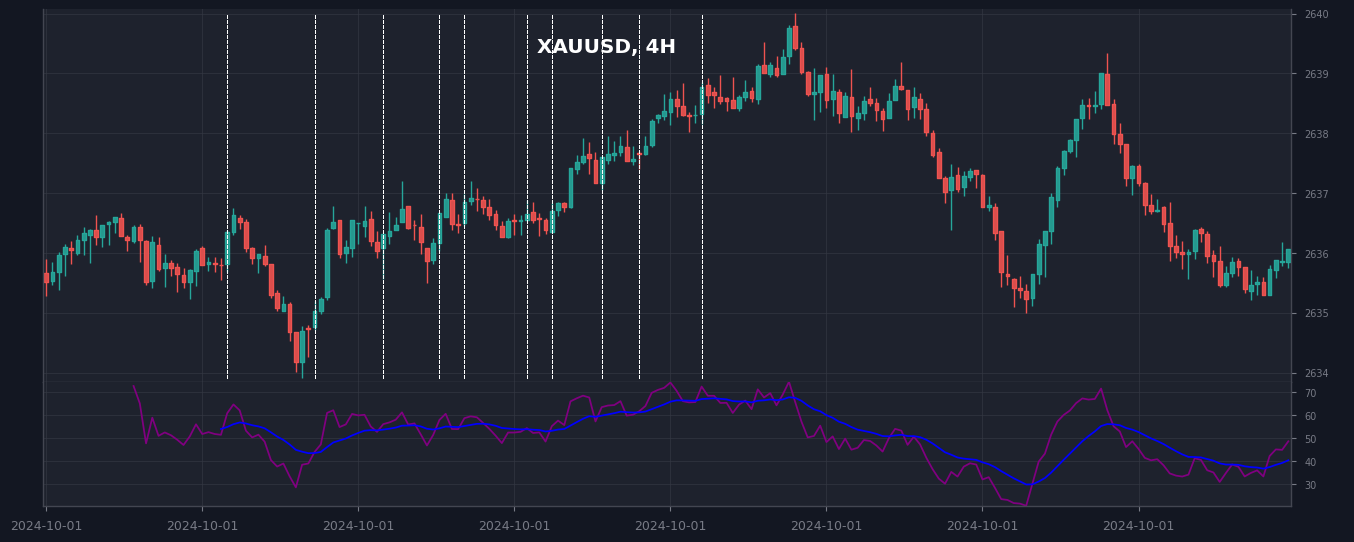

2025-09-26 16:37:40,211 - INFO - Chart 60ca4022-4386-478b-834d-9de0d63227cb generated successfully in 6.20s


In [13]:
# --- TradingView Configuration ---

dpart = tokyo[:200]

tradingview_config_4H = {
    'title': 'XAUUSD, 4H',                # TradingView style title
    'style': tradingview_dark,             # Use dark theme
    'type': 'candle',
    'volume': False,                      # Disable volume bars
    'show_nontrading': False,             # Ensure no extra y-axis spacing
    'datetime_format': '%Y-%m-%d',        # Format x-axis to show date only
    'xlabel': '',                         # Remove x-axis label
    'ylabel': '',                         # Remove y-axis label
    'xrotation': 0                        # Horizontal date labels
}

chartter.plot(
    dpart,
    addplot = [
        mpf.make_addplot(dpart['RSI_14'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot(dpart['EMA_15'], panel=1, color='blue', ylabel='ema15'),
    ],
    config=tradingview_config_4H,
    vlines=dict(
        vlines=signal_times[:10],
        colors='white',
        linewidths=0.7,
        linestyle="--"
    )
)

In [14]:
dta = dpart.copy()


dta['SL'] = dta['low'] - (dta ['high'] - dta ['low'])


dta['TP'] = dta['close'] + (dta ['high'] - dta ['low']) * 2


dta.head(3)

,open,high,low,close,volume,RSI_14,EMA_15,RSI_14_crossed_up_EMA_15,SL,TP
datetime,,,,,,,,,,
2024-10-01 00:00:00,2635.660,2635.899,2635.290,2635.519,89,NaN,NaN,0,2634.681,2636.737
2024-10-01 00:01:00,2635.535,2635.849,2635.463,2635.687,72,NaN,NaN,0,2635.077,2636.459
2024-10-01 00:02:00,2635.682,2636.025,2635.382,2635.975,86,NaN,NaN,0,2634.739,2637.261


In [15]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.patches as mpatches

# Get row numbers (integer positions) where signal is 1
row_numbers = np.where(dta['RSI_14_crossed_up_EMA_15'] == 1)[0]

# Extract SL and TP values for those rows
signal = dta[dta['RSI_14_crossed_up_EMA_15'] == 1]
sl_array = signal['SL'].to_numpy()
tp_array = signal['TP'].to_numpy()

# Optional: combine into structured array
signal_array = np.array(list(zip(row_numbers, sl_array, tp_array)),
                        dtype=[('row', int), ('SL', float), ('TP', float)])

signal_array

array([( 29, 2634.969, 2637.774), ( 43, 2634.222, 2636.003),
       ( 54, 2634.822, 2637.802), ( 63, 2635.422, 2637.902),
       ( 67, 2635.934, 2637.906), ( 77, 2636.229, 2637.309),
       ( 81, 2635.849, 2637.7  ), ( 89, 2636.488, 2638.715),
       ( 95, 2637.1  , 2638.265), (105, 2637.461, 2640.156),
       (112, 2638.192, 2639.395), (114, 2637.821, 2640.447),
       (118, 2638.581, 2640.103), (136, 2638.212, 2639.489),
       (158, 2634.589, 2636.713), (190, 2635.274, 2636.509),
       (196, 2634.796, 2636.732)],
      dtype=[('row', '<i8'), ('SL', '<f8'), ('TP', '<f8')])

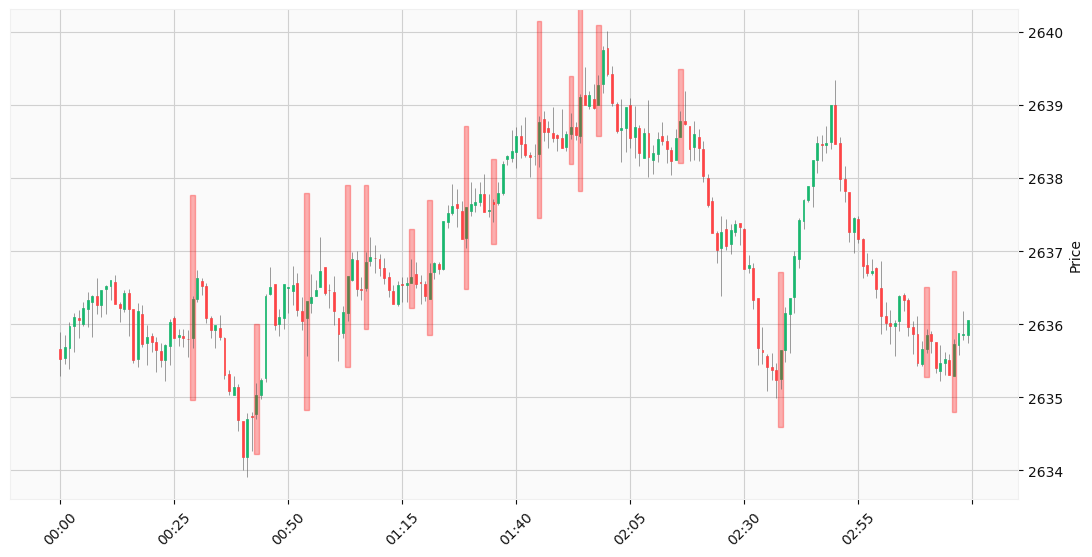

In [16]:
# -----------------------------
# 3. Define function to draw rectangles
# -----------------------------
def draw_signal_boxes(ax, signal_array):
    for entry in signal_array:
        row = entry['row']
        sl = entry['SL']
        tp = entry['TP']
        rect = mpatches.Rectangle(
            (row - 0.5, sl),   # bottom-left corner: x=row, y=SL
            1,                 # width = 1 candle
            tp - sl,           # height = TP - SL
            color='red',
            alpha=0.3
        )
        ax.add_patch(rect)

# -----------------------------
# 4. Plot candlestick chart
# -----------------------------
fig, axes = mpf.plot(
    dta,
    type='candle',
    style='yahoo',
    figsize=(14, 7),
    returnfig=True
)

# axes[0] is the main price axes
draw_signal_boxes(axes[0], signal_array)

mpf.show()


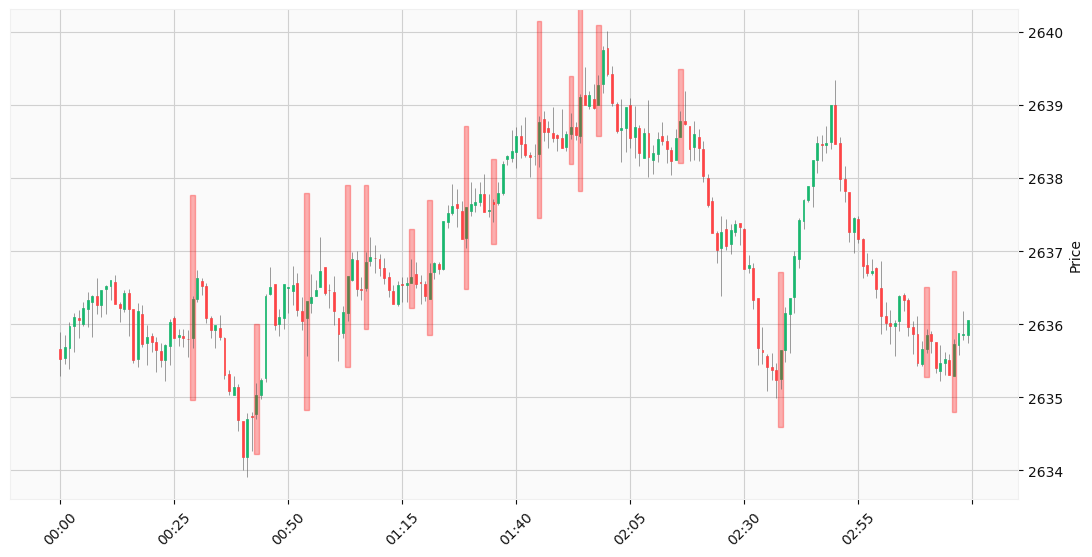

In [17]:
import matplotlib.patches as mpatches
import mplfinance as mpf
import numpy as np

# -----------------------------
# 1. Slice last 50 candles
# -----------------------------
dta_slice = dta.copy()  # last 50 candles
slice_start = dta.index.get_loc(dta_slice.index[0])  # starting row in full df

# -----------------------------
# 2. Adjust signal array for sliced data
# -----------------------------
# Only keep signals within the last 50 candles
mask = (signal_array['row'] >= slice_start)
signal_slice = signal_array[mask]

# Adjust row numbers to match sliced DataFrame (row 0 = first candle in slice)
signal_slice['row'] = signal_slice['row'] - slice_start

# -----------------------------
# 3. Function to draw rectangles
# -----------------------------
def draw_signal_boxes(ax, signal_array):
    for entry in signal_array:
        row = entry['row']
        sl = entry['SL']
        tp = entry['TP']
        rect = mpatches.Rectangle(
            (row - 0.5, sl),   # bottom-left corner: x=row, y=SL
            1,                 # width = 1 candle
            tp - sl,           # height = TP - SL
            color='red',
            alpha=0.3
        )
        ax.add_patch(rect)

# -----------------------------
# 4. Plot candlestick chart
# -----------------------------
fig, axes = mpf.plot(
    dta_slice,
    type='candle',
    style='yahoo',
    figsize=(14, 7),
    returnfig=True
)

draw_signal_boxes(axes[0], signal_slice)
mpf.show()


In [18]:
dta

,open,high,low,close,volume,RSI_14,EMA_15,RSI_14_crossed_up_EMA_15,SL,TP
datetime,,,,,,,,,,
2024-10-01 00:00:00,2635.660,2635.899,2635.290,2635.519,89,NaN,NaN,0,2634.681,2636.737
2024-10-01 00:01:00,2635.535,2635.849,2635.463,2635.687,72,NaN,NaN,0,2635.077,2636.459
2024-10-01 00:02:00,2635.682,2636.025,2635.382,2635.975,86,NaN,NaN,0,2634.739,2637.261
2024-10-01 00:03:00,2635.977,2636.152,2635.616,2636.097,89,NaN,NaN,0,2635.080,2637.169
2024-10-01 00:04:00,2636.081,2636.200,2635.810,2636.052,72,NaN,NaN,0,2635.420,2636.832
...,...,...,...,...,...,...,...,...,...,...
2024-10-01 03:15:00,2635.518,2635.594,2635.303,2635.304,64,33.422115,36.811075,0,2635.012,2635.886
2024-10-01 03:16:00,2635.299,2635.802,2635.299,2635.726,61,42.289161,37.495836,1,2634.796,2636.732
2024-10-01 03:17:00,2635.714,2635.887,2635.575,2635.880,57,45.159564,38.453802,0,2635.263,2636.504


In [19]:
# Save DataFrame as Parquet
dta.to_parquet("sampleSignal.parquet", index=True)  # index=True to keep datetime index
